# **Segmentação de clientes**

In [976]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# pip install yellowbrick

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from datetime import datetime, timedelta

%matplotlib inline

In [977]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [978]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Carregamento de dados

In [979]:
df_vendas = pd.read_csv('data/tfvenda.csv')
df_clientes = pd.read_csv('data/DimCliente.csv')
df_produtos = pd.read_csv('data/DimProduto.csv')
df_tempo = pd.read_csv('data/DimTempo.csv')

In [980]:
df_vendas

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal
0,1,2012-11-24,453,64,3,84.55,4.0,253.65,Loja Física
1,2,2010-11-24,113,140,5,161.37,25.0,806.85,Loja Física
2,3,2010-07-07,202,27,4,62.03,13.0,248.11,Loja Física
3,4,2019-05-10,560,123,5,214.03,49.0,1070.15,Loja Física
4,5,2019-04-15,168,21,4,129.40,29.0,517.58,Loja Física
...,...,...,...,...,...,...,...,...,...
15878,17879,2022-09-01,1094,90,2,642.87,21.0,1285.73,Online
15879,17880,2024-01-27,1298,61,1,203.33,16.0,203.33,Online
15880,17881,2021-03-19,2032,123,3,165.25,44.0,495.74,Online
15881,17882,2023-01-09,458,22,5,206.56,5.0,1032.80,Online


In [981]:
df_clientes

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25
...,...,...,...,...,...,...,...,...
1986,2095,Miguel Antunes,M,Viúvo,Técnico de Marketing,Guarda,Guarda,1997-08-08
1987,2096,Isabel Cardoso,F,Viúvo,Carpinteiro,Celorico de Basto,Braga,1989-05-05
1988,2097,Nádia Carneiro,F,Viúvo,Farmacêutico,Braga,Braga,1997-11-03
1989,2098,Brian Costa,M,Casado,Programador,Valongo,Porto,1994-06-05


In [982]:
df_produtos

,ProdutoId,Nome,Marca,Categoria
0,1,Rato Logitech MX Master,Logitech,Perifericos
1,2,Logitech Rato MX Anywhere,Logitech,Perifericos
2,3,Teclado Mecânico Corsair K70,Corsair,Perifericos
3,4,Teclado Gaming Razer BlackWidow,Razer,Perifericos
4,5,"Monitor Dell 24"",Dell,Monitores\n6,Monitor 27 ...",HP,Monitores
...,...,...,...,...
168,171,Rato SteelSeries Rival 5,Logitech,Perifericos
169,172,Teclado Razer Pro Type,Acer,Monitores
170,173,"Monitor 27 ASUS ProArt""",BenQ,Monitores
171,174,Headset Sennheiser HD 560S,Sony,Audio


In [983]:
df_tempo

,DataId,Mes,Trimestre,Ano,FimDeSemana,Feriado
0,2010-01-01,1,1,2010,N,S
1,2010-01-02,1,1,2010,S,N
2,2010-01-03,1,1,2010,S,N
3,2010-01-04,1,1,2010,N,N
4,2010-01-05,1,1,2010,N,N
...,...,...,...,...,...,...
5177,2025-04-07,4,2,2025,N,N
5178,2025-04-08,4,2,2025,N,N
5179,2025-04-09,4,2,2025,N,N
5180,2025-04-10,4,2,2025,N,N


In [984]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15883 entries, 0 to 15882
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VendaId              15883 non-null  int64  
 1   DataId               15883 non-null  object 
 2   ClienteId            15883 non-null  int64  
 3   ProdutoId            15883 non-null  int64  
 4   Quantidade           15883 non-null  int64  
 5   PrecoUnitario        15883 non-null  float64
 6   PercentagemDesconto  15883 non-null  float64
 7   ValorTotal           15883 non-null  float64
 8   Canal                15883 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 1.1+ MB


In [985]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ClienteId       1991 non-null   int64 
 1   Nome            1991 non-null   object
 2   Sexo            1991 non-null   object
 3   EstadoCivil     1991 non-null   object
 4   Profissao       1991 non-null   object
 5   Concelho        1991 non-null   object
 6   Distrito        1991 non-null   object
 7   DataNascimento  1991 non-null   object
dtypes: int64(1), object(7)
memory usage: 124.6+ KB


In [986]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProdutoId  173 non-null    int64 
 1   Nome       173 non-null    object
 2   Marca      173 non-null    object
 3   Categoria  173 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


In [987]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5182 entries, 0 to 5181
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DataId       5182 non-null   object
 1   Mes          5182 non-null   int64 
 2   Trimestre    5182 non-null   int64 
 3   Ano          5182 non-null   int64 
 4   FimDeSemana  5182 non-null   object
 5   Feriado      5182 non-null   object
dtypes: int64(3), object(3)
memory usage: 243.0+ KB


## Limpeza e transformação de dados

### Missing values

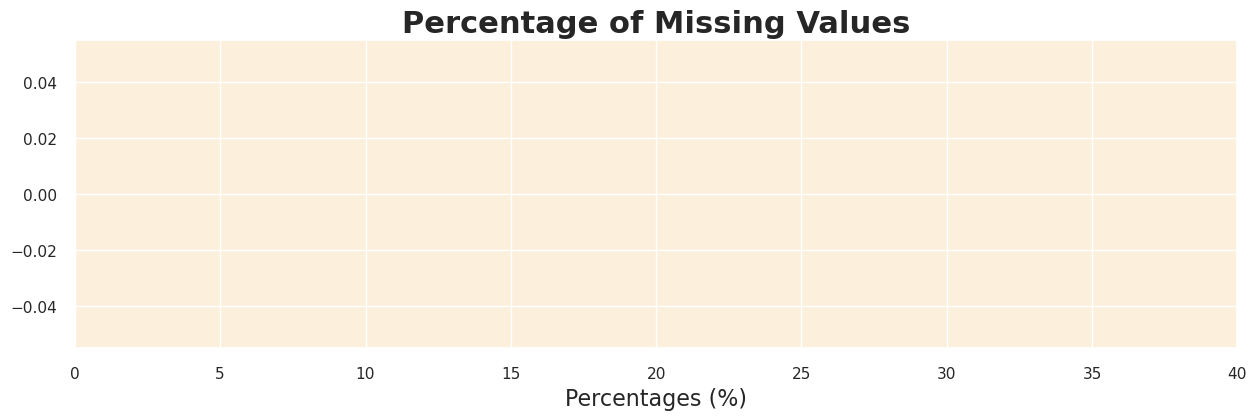

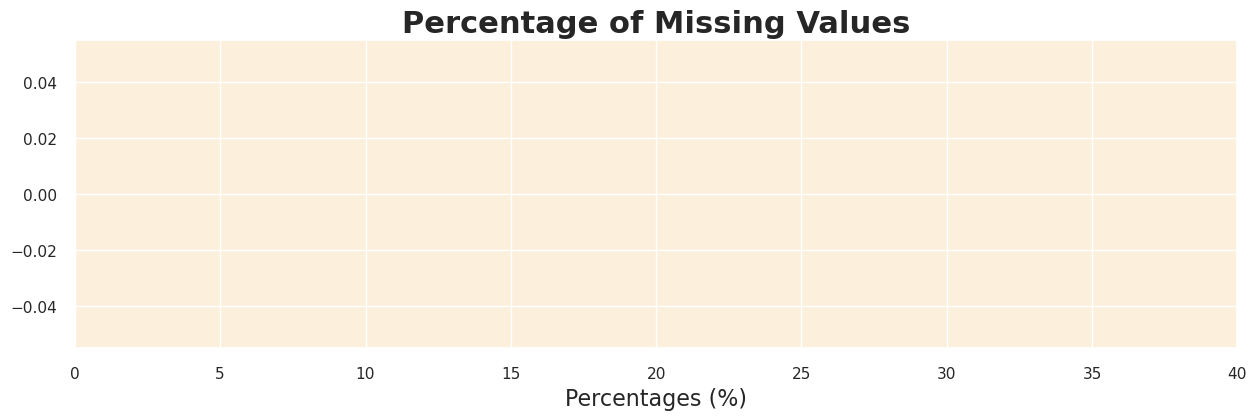

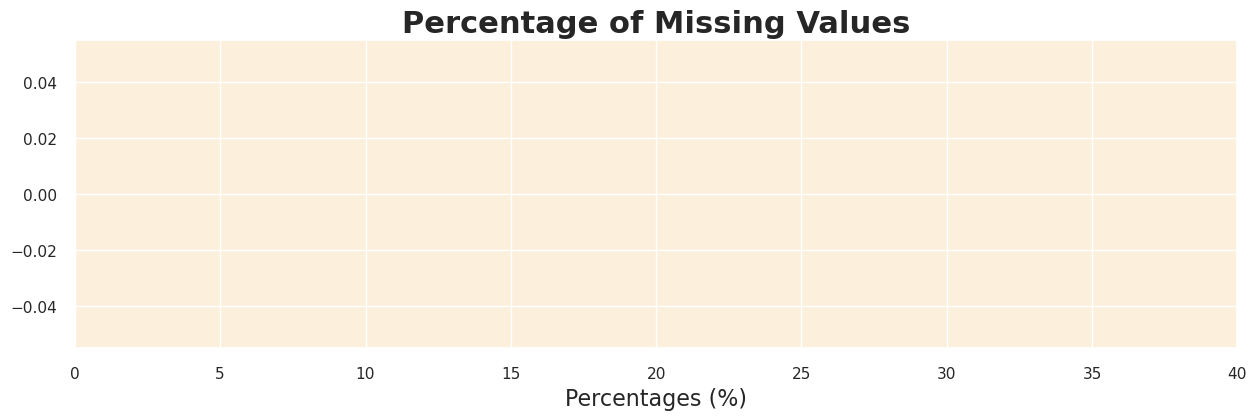

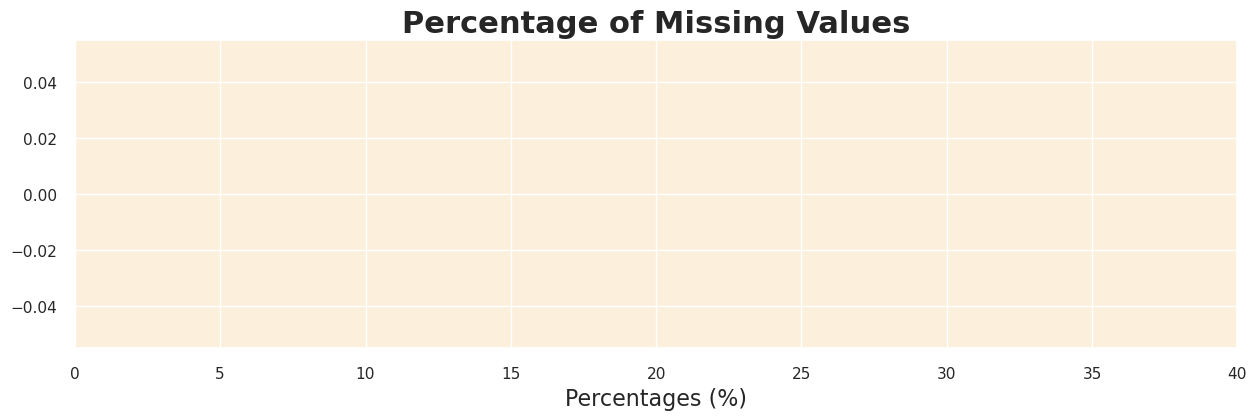

In [988]:
dfs = [df_vendas, df_clientes, df_produtos, df_tempo]

for df in dfs:
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

    missing_percentage.sort_values(ascending=True, inplace=True)

    fig, ax = plt.subplots(figsize=(15, 4))
    ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

    for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
        ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

    ax.set_xlim([0, 40])

    plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
    plt.xlabel('Percentages (%)', fontsize=16)
    plt.show()

In [989]:
for df in dfs:
    df.isnull().sum().sum()

### Duplicados

In [990]:
for df in dfs:
    duplicate_rows = df[df.duplicated(keep=False)]
    duplicate_rows.head(10)
    if duplicate_rows.empty:
        print(f"No duplicate rows in {df.columns[0]}")

No duplicate rows in VendaId
No duplicate rows in ClienteId
No duplicate rows in ProdutoId
No duplicate rows in DataId


## Analise de dados

### Percentagem de compras por distrito

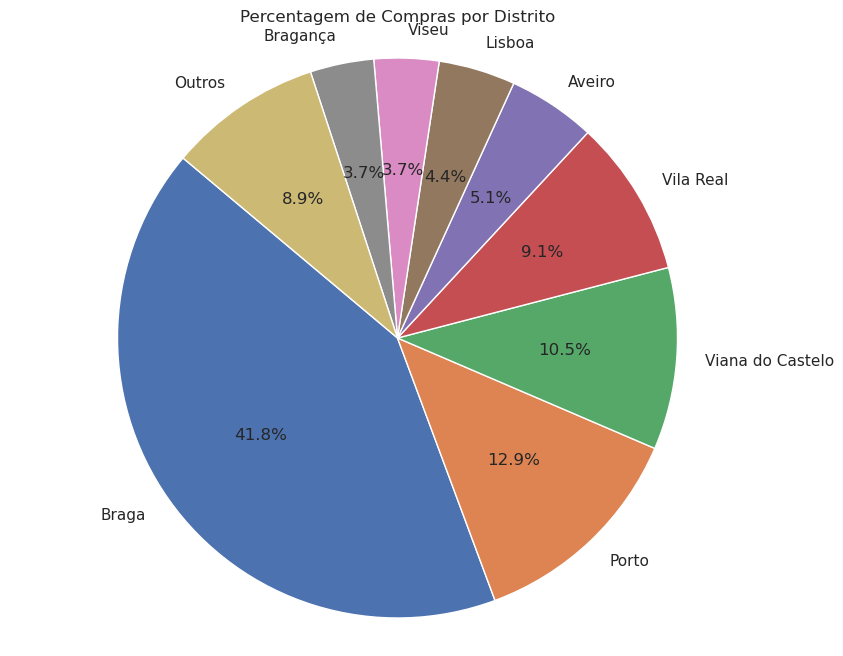

In [991]:
df_vendas_com_distrito = df_vendas.merge(df_clientes[['ClienteId', 'Distrito']], on='ClienteId', how='left')

compras_por_distrito = df_vendas_com_distrito['Distrito'].value_counts()

percentagem_por_distrito = compras_por_distrito / compras_por_distrito.sum() * 100

principais = percentagem_por_distrito[percentagem_por_distrito >= 3]
residuais = percentagem_por_distrito[percentagem_por_distrito < 2]

principais['Outros'] = residuais.sum()

plt.figure(figsize=(10, 8))
plt.pie(principais, labels=principais.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Distrito')
plt.axis('equal')
plt.show()

### Percentagem de compras por profissão

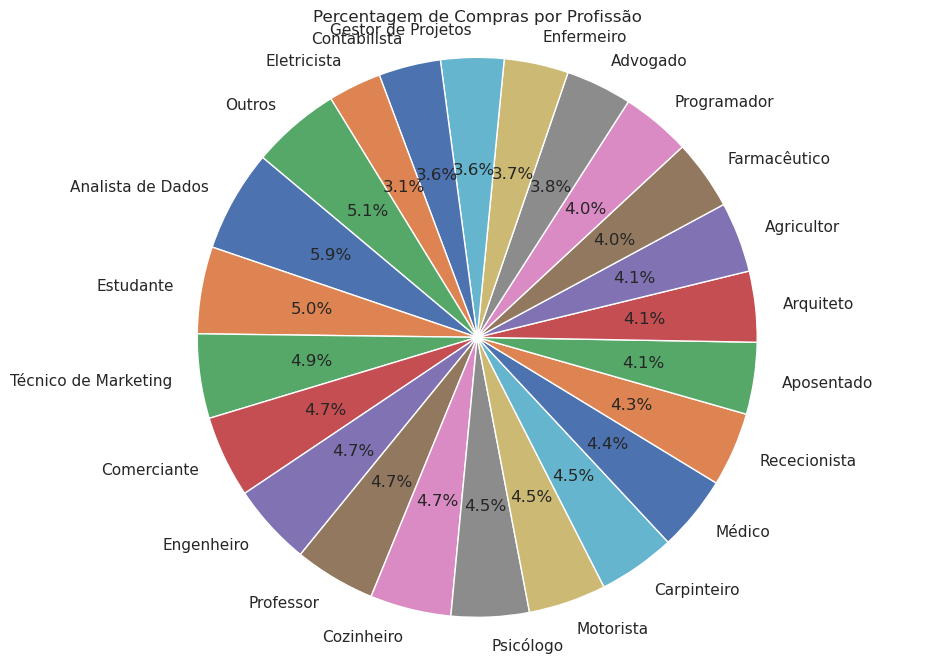

In [992]:
df_vendas_com_profissao = df_vendas.merge(df_clientes[['ClienteId', 'Profissao']], on='ClienteId', how='left')

compras_por_profissao = df_vendas_com_profissao['Profissao'].value_counts()

percentagem_por_profissao = compras_por_profissao / compras_por_profissao.sum() * 100

principais_profissoes = percentagem_por_profissao[percentagem_por_profissao >= 3]
residuais_profissoes = percentagem_por_profissao[percentagem_por_profissao < 3]

principais_profissoes['Outros'] = residuais_profissoes.sum()

plt.figure(figsize=(12, 8))
plt.pie(principais_profissoes, labels=principais_profissoes.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Profissão')
plt.axis('equal')
plt.show()


### Percentagem de cada categoria de produto nas compras

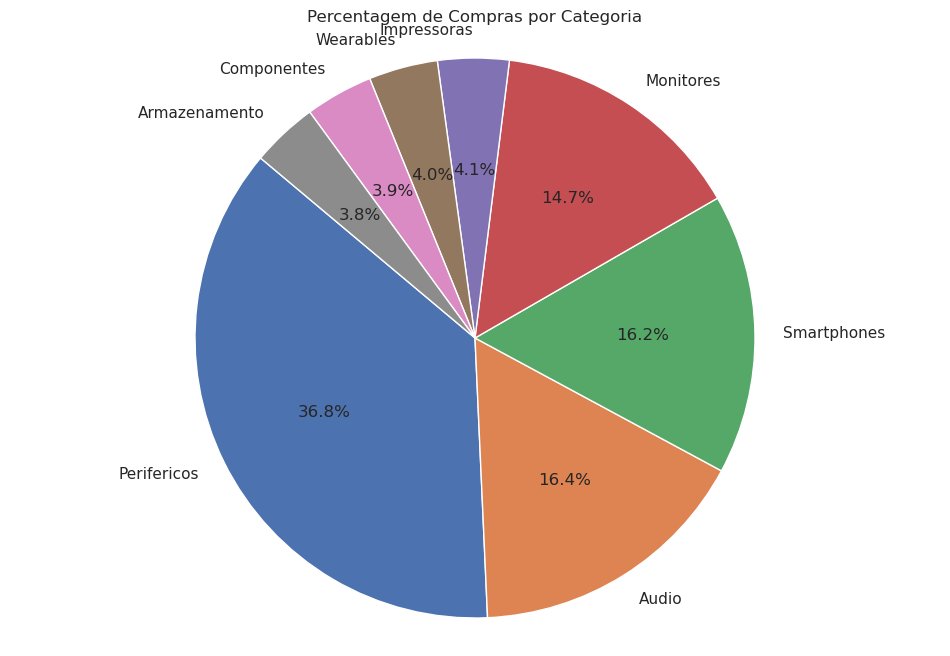

In [993]:
compras_por_categoria = df_vendas.merge(df_produtos[['ProdutoId', 'Categoria']], on='ProdutoId', how='left')
compras_por_categoria = compras_por_categoria['Categoria'].value_counts()
percentagem_por_categoria = compras_por_categoria / compras_por_categoria.sum() * 100
plt.figure(figsize=(12, 8))
plt.pie(percentagem_por_categoria, labels=percentagem_por_categoria.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Categoria')
plt.axis('equal')
plt.show()

## Feature engineering

### PrecoFinal
Preço final de uma compra considerando a quntidade, preço unitário e o desconto por unidade

In [994]:
df_vendas['PrecoFinal'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
df_vendas.head(3)

,VendaId,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal,PrecoFinal
0,1,2012-11-24,453,64,3,84.55,4.0,253.65,Loja Física,243.5040
1,2,2010-11-24,113,140,5,161.37,25.0,806.85,Loja Física,605.1375
2,3,2010-07-07,202,27,4,62.03,13.0,248.11,Loja Física,215.8644


### Idade

In [995]:
df_clientes['DataNascimento'] = pd.to_datetime(df_clientes['DataNascimento'])

today = pd.Timestamp.today()
df_clientes['Idade'] = df_clientes['DataNascimento'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20


### Percentagem de compras online

In [996]:
compras_online = df_vendas[df_vendas['Canal'] == 'Online'].groupby('ClienteId').size()

compras_totais = df_vendas.groupby('ClienteId').size()

percentagem_online = (compras_online / compras_totais * 100).fillna(0)

df_clientes['PercentagemComprasOnline'] = df_clientes['ClienteId'].map(percentagem_online)

df_clientes.head(3)


,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.000000
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032


### Frequencia
Total de transações e de produtos comprados

In [997]:
total_transacoes = df_vendas.groupby('ClienteId')['VendaId'].nunique().reset_index()
total_transacoes.rename(columns={'VendaId': 'TotalTransacoes'}, inplace=True)

total_compras = df_vendas.groupby('ClienteId')['Quantidade'].sum().reset_index()
total_compras.rename(columns={'Quantidade': 'TotalCompras'}, inplace=True)

df_clientes = pd.merge(df_clientes, total_transacoes, on='ClienteId', how='left')
df_clientes = pd.merge(df_clientes, total_compras, on='ClienteId', how='left')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,30,91
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.000000,30,98
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,31,97


### Total gasto e Valor Médio de transações

In [998]:
df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
total_spend = df_vendas.groupby('ClienteId')['Total_Spend'].sum().reset_index()

total_transactions = df_vendas.groupby('ClienteId').size().reset_index(name='Total_Transactions')

average_transaction_value = total_spend.merge(total_transactions, on='ClienteId')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, total_spend, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, average_transaction_value[['ClienteId', 'Average_Transaction_Value']], on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,30,91,18650.0270,621.667567
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.000000,30,98,14033.2457,467.774857
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,31,97,17554.6157,566.277926


### Diversidade de produtos

Produtos unicos comprados

In [999]:
unique_products_purchased = df_vendas.groupby('ClienteId')['ProdutoId'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProdutoId': 'ProdutosUnicosComprados'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='ClienteId')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,30,91,18650.0270,621.667567,27
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.000000,30,98,14033.2457,467.774857,28
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,31,97,17554.6157,566.277926,30


### Media de dias entre compras e Dia e Hora favoritos para comprar

In [1000]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Day_Of_Week'] = df_vendas['DataCompra'].dt.dayofweek
df_vendas['Hour'] = 12

df_vendas = df_vendas.sort_values(['ClienteId', 'DataCompra'])

df_vendas['InvoiceDay'] = df_vendas['DataCompra'].dt.date
days_between_purchases = df_vendas.groupby('ClienteId')['InvoiceDay'].apply(lambda x: (x.diff()).dropna().apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('ClienteId').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

favorite_shopping_day = df_vendas.groupby(['ClienteId', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Day_Of_Week']]

favorite_shopping_hour = df_vendas.groupby(['ClienteId', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Hour']]

customer_data = customer_data.copy()
customer_data = pd.merge(customer_data, average_days_between_purchases, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='ClienteId', how='left')

day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
customer_data['Favorite_Shopping_Day'] = customer_data['Day_Of_Week'].map(day_mapping)

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,30,91,18650.0270,621.667567,27,168.827586,0,12,Monday
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.000000,30,98,14033.2457,467.774857,28,190.310345,4,12,Friday
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,31,97,17554.6157,566.277926,30,162.733333,6,12,Sunday


### Media de gastos mensais

In [1001]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Year'] = df_vendas['DataCompra'].dt.year
df_vendas['Month'] = df_vendas['DataCompra'].dt.month

if 'Total_Spend' not in df_vendas.columns:
    df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)

monthly_spending = df_vendas.groupby(['ClienteId', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('ClienteId')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('ClienteId')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

if 'customer_data' not in locals():
    customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, spending_trends, on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,...,18650.0270,621.667567,27,168.827586,0,12,Monday,690.741741,342.158729,-3.993210
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.000000,...,14033.2457,467.774857,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,...,17554.6157,566.277926,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763


In [1002]:
customer_data['ClienteId'] = customer_data['ClienteId'].astype(str)

customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,...,18650.027,621.667567,27,168.827586,0,12,Monday,690.741741,342.158729,-3.99321
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.0,...,14033.2457,467.774857,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,...,17554.6157,566.277926,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23,38,2.564103,...,27121.2541,695.416772,36,109.789474,1,12,Tuesday,874.879165,509.424617,6.329541
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,68,12.0,...,15018.9693,600.758772,24,208.5,5,12,Saturday,682.680423,389.821981,25.012468
5,105,Sandro Nunes-Magalhães,M,Divorciado,Arquiteto,Arcos de Valdevez,Viana do Castelo,1967-07-06,57,7.317073,...,25636.4983,625.280446,35,130.825,3,12,Thursday,692.878332,365.988879,-2.86165
6,106,Jorge Pinto,M,Casado,Farmacêutico,Vidigueira,Beja,1981-04-03,44,10.526316,...,19437.8554,511.522511,34,134.810811,3,12,Thursday,555.367297,413.042209,6.937962
7,107,Rui Fernandes-Leal,M,Viúvo,Cozinheiro,Cabeceiras de Basto,Braga,1975-03-07,50,11.111111,...,17419.4475,645.164722,26,206.730769,0,12,Monday,669.97875,443.074777,14.508418
8,108,Carminho da Jesus,F,Divorciado,Estudante,Guimarães,Braga,1948-10-08,76,5.882353,...,20629.6481,606.754356,31,147.181818,5,12,Saturday,736.773146,497.132228,9.49989
9,109,Inês Castro,F,Divorciado,Médico,Felgueiras,Porto,1993-11-27,31,2.777778,...,22669.2993,629.702758,34,114.142857,0,12,Monday,666.744097,418.810751,3.196195


In [1003]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ClienteId                       1991 non-null   string        
 1   Nome                            1991 non-null   string        
 2   Sexo                            1991 non-null   string        
 3   EstadoCivil                     1991 non-null   string        
 4   Profissao                       1991 non-null   string        
 5   Concelho                        1991 non-null   string        
 6   Distrito                        1991 non-null   string        
 7   DataNascimento                  1991 non-null   datetime64[ns]
 8   Idade                           1991 non-null   Int64         
 9   PercentagemComprasOnline        1991 non-null   Float64       
 10  TotalTransacoes                 1991 non-null   Int64         
 11  Tota

### Categoria mais comprada

In [1004]:
df_vendas = df_vendas.merge(df_produtos[['ProdutoId', 'Categoria']], on='ProdutoId', how='left')

compras_por_categoria = df_vendas.groupby(['ClienteId', 'Categoria']).size().reset_index(name='NumCompras')

categoria_favorita = compras_por_categoria.loc[
    compras_por_categoria.groupby('ClienteId')['NumCompras'].idxmax()
]

categoria_favorita.rename(columns={'Categoria': 'CategoriaFavorita'}, inplace=True)

customer_data['ClienteId'] = customer_data['ClienteId'].astype('int64')
categoria_favorita['ClienteId'] = categoria_favorita['ClienteId'].astype('int64')

customer_data = customer_data.merge(categoria_favorita[['ClienteId', 'CategoriaFavorita']], on='ClienteId', how='left')

customer_data.head(3)


,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,CategoriaFavorita
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,...,621.667567,27,168.827586,0,12,Monday,690.741741,342.158729,-3.99321,Perifericos
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.0,...,467.774857,28,190.310345,4,12,Friday,467.774857,365.963484,-1.013417,Perifericos
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,...,566.277926,30,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763,Perifericos


## Deteção e tratamento de outliers

In [1005]:
model = IsolationForest(contamination=0.05, random_state=0)

numeric_columns = customer_data.select_dtypes(include=['number']).columns

numeric_data = customer_data[numeric_columns].fillna(customer_data[numeric_columns].mean())

customer_data['Outlier_Scores'] = model.fit_predict(numeric_data.to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,CategoriaFavorita,Outlier_Scores,Is_Outlier
0,100,João Garcia,M,Divorciado,Comerciante,Celorico de Basto,Braga,1985-10-26,39,6.666667,...,168.827586,0,12,Monday,690.741741,342.158729,-3.99321,Perifericos,-1,1
1,101,Gustavo Andrade,M,Solteiro,Analista de Dados,Vizela,Braga,1947-05-31,77,10.0,...,190.310345,4,12,Friday,467.774857,365.963484,-1.013417,Perifericos,-1,1
2,102,Salomé Matos,F,Divorciado,Gestor de Projetos,Póvoa de Varzim,Porto,2004-10-17,20,16.129032,...,162.733333,6,12,Sunday,626.950561,417.946527,-0.389763,Perifericos,-1,1
3,103,Anita de Silva,F,Casado,Cozinheiro,Sabugal,Guarda,1987-03-23,38,2.564103,...,109.789474,1,12,Tuesday,874.879165,509.424617,6.329541,Perifericos,-1,1
4,104,Diana Castro-Nogueira,F,Casado,Técnico de Marketing,Bragança,Bragança,1956-09-25,68,12.0,...,208.5,5,12,Saturday,682.680423,389.821981,25.012468,Perifericos,-1,1


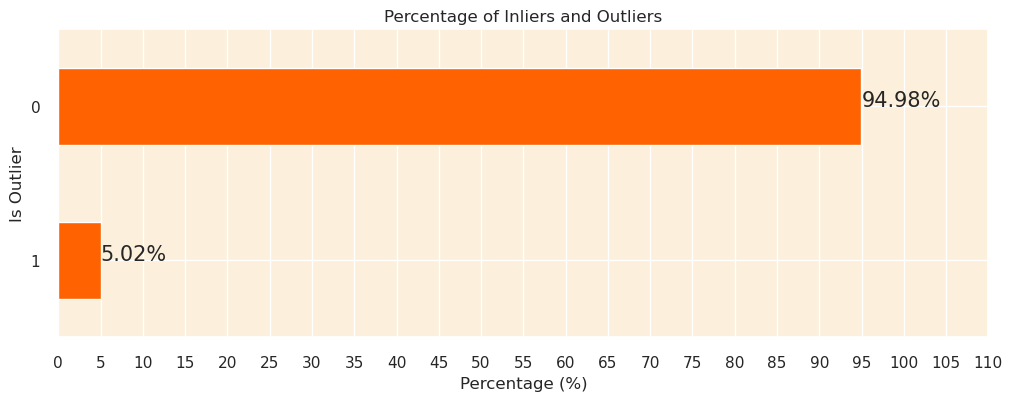

In [1006]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [1007]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [1008]:
customer_data_cleaned.shape[0]

1891

## Correlation analysis

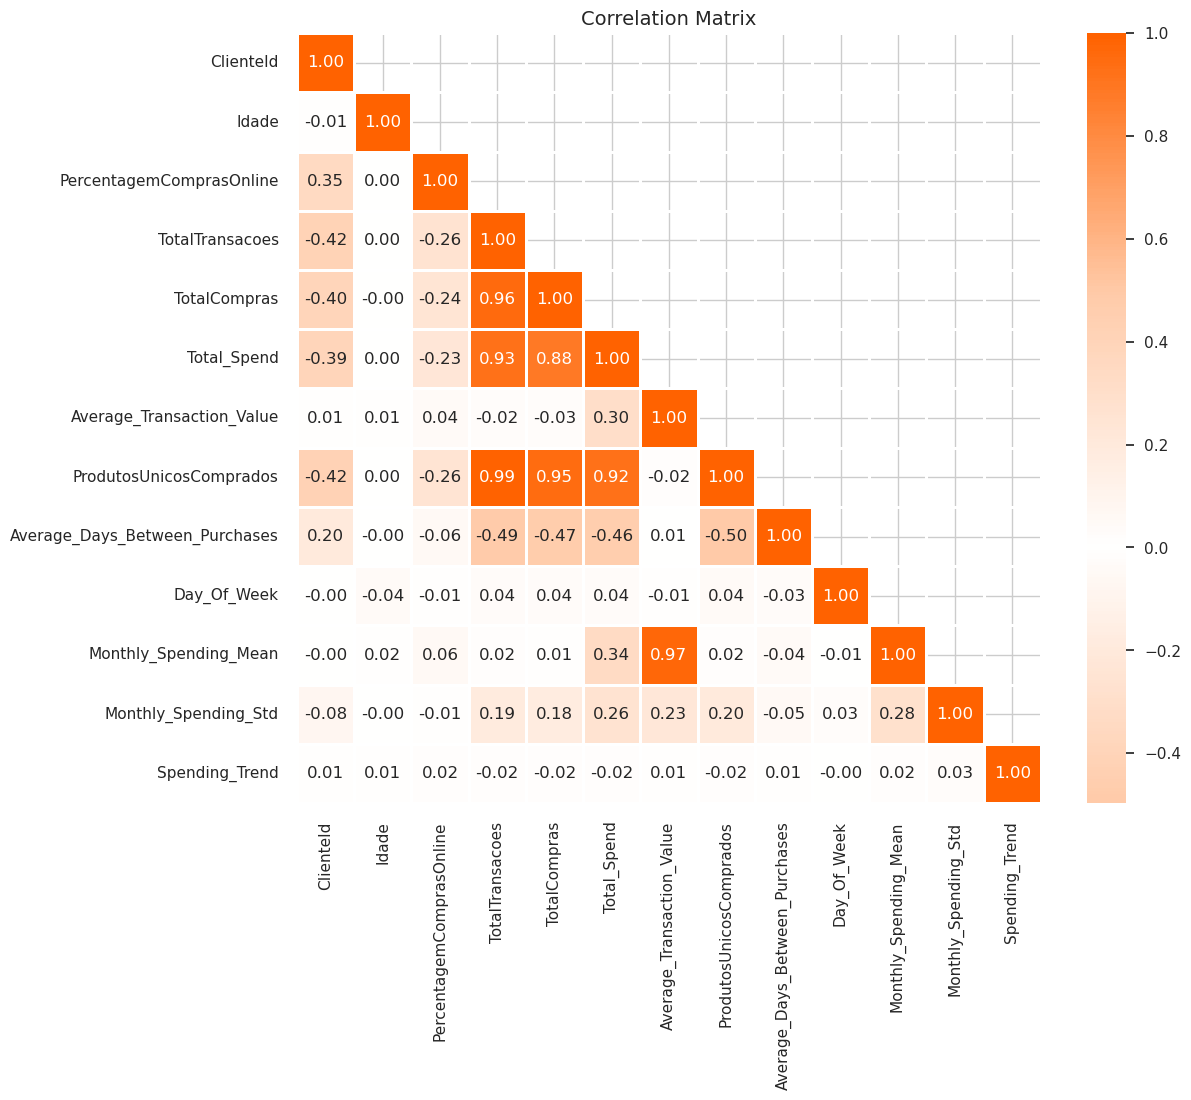

In [1009]:
sns.set_style('whitegrid')

numeric_columns = customer_data_cleaned.select_dtypes(include=['number']).columns
numeric_columns = [col for col in numeric_columns if col != 'Hour']

corr = customer_data_cleaned[numeric_columns].corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Feature scaling

In [1010]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['ClienteId', 'Day_Of_Week', 'Nome', 'Sexo', 'DataId', 'DataCompra', 'InvoiceDay', 'Favorite_Shopping_Day', 'Concelho', 'Distrito', 'DataNascimento', 'EstadoCivil', 'Profissao', 'CategoriaFavorita']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Transaction_Value,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,CategoriaFavorita
0,114,Renato Freitas,M,Casado,Aposentado,Vizela,Braga,1961-10-14,0.785462,-1.139510,...,-0.246533,5.029698,-1.179228,3,0.0,Thursday,0.117660,1.214906,-0.078141,Audio
1,117,Mara-Teresa Nogueira,F,Casado,Aposentado,Guimarães,Braga,1970-12-19,0.295531,-1.692762,...,0.224948,3.931855,-1.131470,1,0.0,Tuesday,0.532229,0.460903,-0.044187,Perifericos
2,120,Kévim Matos,M,Divorciado,Carpinteiro,Celorico de Basto,Braga,1967-10-18,0.458841,-1.749004,...,-0.234540,6.127540,-1.298016,2,0.0,Wednesday,-0.072368,0.515822,-0.064621,Audio
3,122,Jorge Santos-Jesus,M,Viúvo,Eletricista,Sabrosa,Vila Real,1989-06-24,-0.738769,-1.589920,...,-0.129600,4.755237,-1.240598,2,0.0,Wednesday,0.072575,0.560971,-0.035367,Monitores
4,127,Jorge Vicente,M,Divorciado,Aposentado,Peso da Régua,Vila Real,1972-08-27,0.186657,-1.707760,...,-0.155995,4.206316,-1.159555,4,0.0,Friday,-0.073868,0.827746,-0.045855,Perifericos


## Dimensionality reduction

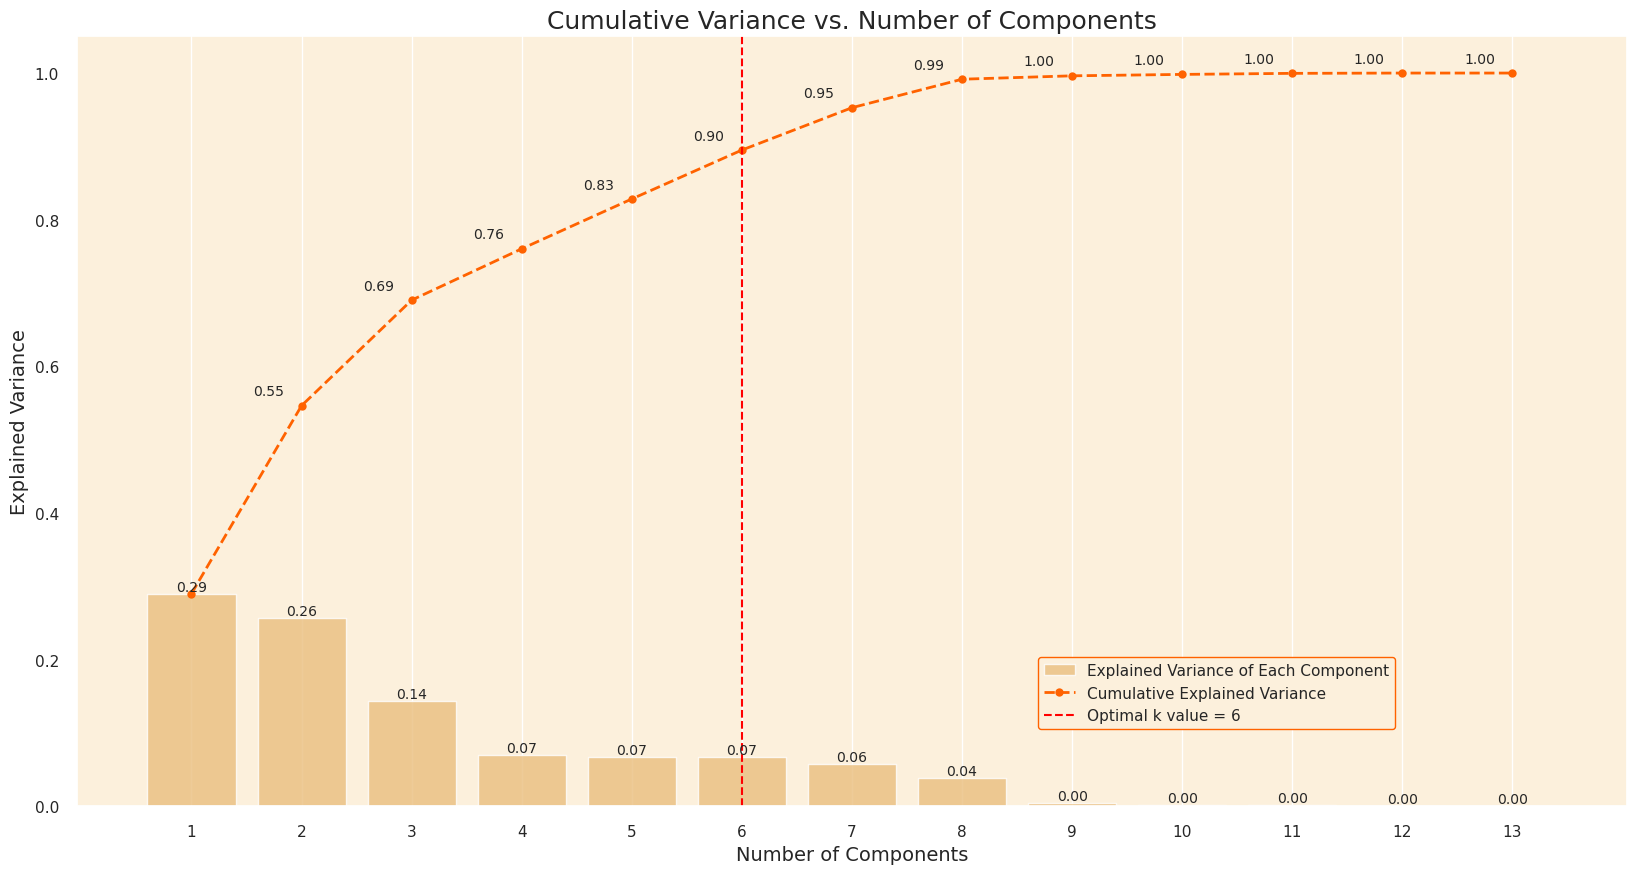

In [1011]:
# Make sure we use only numeric columns for PCA
numeric_columns = customer_data_scaled.select_dtypes(include=['number']).columns
customer_data_numeric = customer_data_scaled[numeric_columns]

# Set CustomerID as the index if it's not already
if 'ClienteId' in customer_data_numeric.columns:
    customer_data_numeric.set_index('ClienteId', inplace=True)

# Fill missing values with the mean of each column
customer_data_numeric_imputed = customer_data_numeric.fillna(customer_data_numeric.mean())

# Apply PCA
pca = PCA().fit(customer_data_numeric_imputed)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                     y=explained_variance_ratio,
                     color='#fcc36d',
                     alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                    marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
          labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
          loc=(0.62, 0.1),
          frameon=True,
          framealpha=1.0,
          edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [1012]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_numeric_imputed)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_numeric_imputed.index

In [1013]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
ClienteId,,,,,,
114,9.451160,-3.045867,-1.187975,-0.450432,0.716027,0.451192
117,6.503939,-4.029842,-0.410290,-0.946923,0.365534,0.144094
120,11.229833,-4.829230,-1.879921,-0.909907,0.548446,0.235094
122,9.508763,-4.113504,-1.414555,-0.871448,-0.230593,-0.689242
127,8.127958,-1.429732,-1.077755,-0.943172,0.419044,0.030553


In [1014]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Garante que usas as mesmas colunas que foram usadas no PCA
features_used = customer_data_numeric_imputed.columns[:pca.components_.shape[1]]

pc_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=features_used
)

# Desta forma, aplica o estilo corretamente
pc_df.style.apply(highlight_top3, axis=0)


,PC1,PC2,PC3,PC4,PC5,PC6
Idade,-0.007459,-0.023909,0.013927,0.065397,0.631254,0.770225
PercentagemComprasOnline,-0.125052,0.053723,0.105458,0.827349,-0.172585,0.058317
TotalTransacoes,0.438988,-0.175258,-0.113879,-0.004037,0.009005,-0.004666
TotalCompras,0.427742,-0.171042,-0.117710,0.000870,0.005157,-0.008163
Total_Spend,0.434562,-0.175032,0.112035,-0.019594,-0.006117,0.008720
Average_Transaction_Value,0.058840,-0.036728,0.656079,-0.056189,-0.040752,0.038042
ProdutosUnicosComprados,0.438847,-0.173550,-0.112343,-0.000435,0.008847,-0.003620
Average_Days_Between_Purchases,-0.251717,0.094376,0.063043,-0.505073,0.127732,-0.074022
Day_Of_Week,0.370492,0.928271,0.014696,-0.004966,0.015258,0.020827
Hour,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000


## K-means clustering

### Nº optimo de clusters - Elbow method

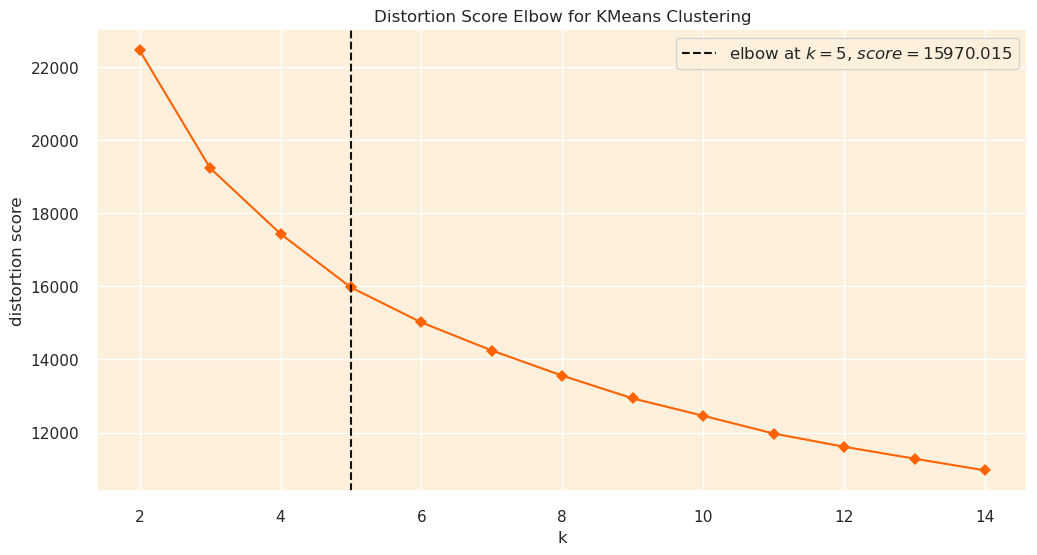

In [1015]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 6))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_numeric_imputed)

# Finalize and render the figure
visualizer.show();

### Nº optimo de clusters - Silhouette method

In [1016]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

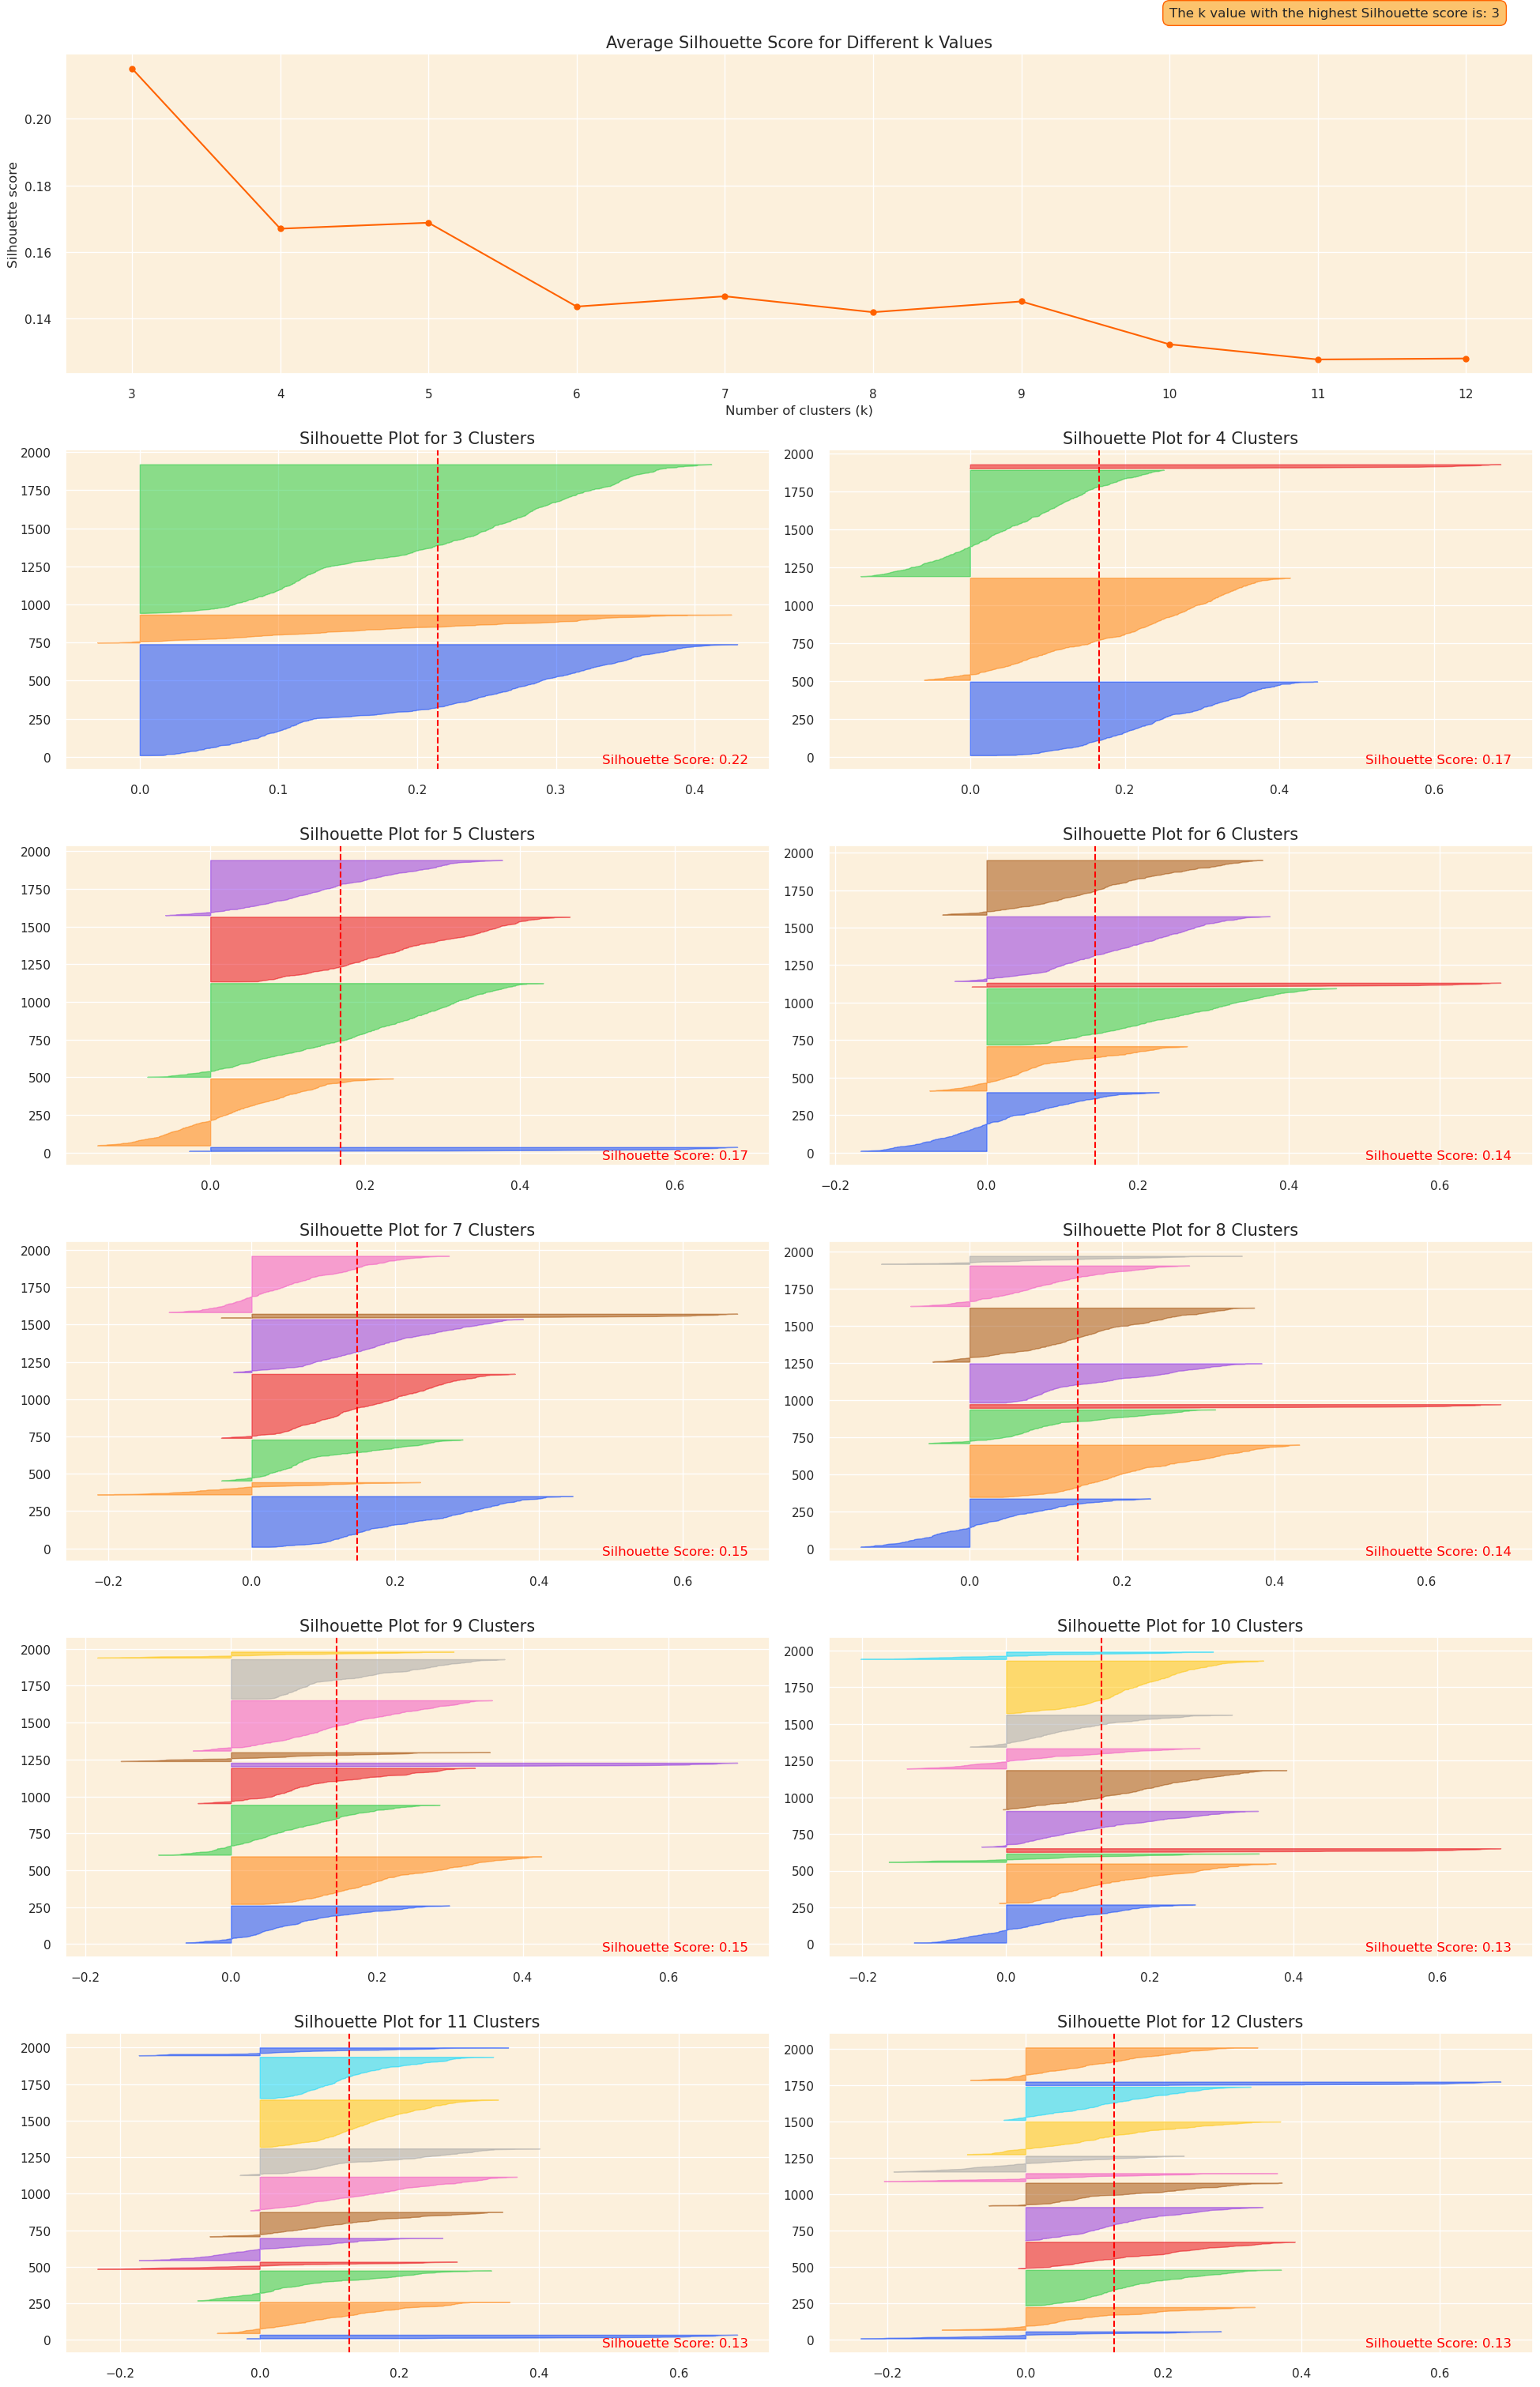

In [1017]:
silhouette_analysis(customer_data_numeric_imputed, 3, 12, figsize=(20, 50))

### Clustering com k-means

In [1018]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_numeric_imputed)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [1019]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissao,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,ProdutosUnicosComprados,Average_Days_Between_Purchases,Day_Of_Week,Hour,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,CategoriaFavorita,cluster
0,114,Renato Freitas,M,Casado,Aposentado,Vizela,Braga,1961-10-14,63,18.518519,...,25,212.038462,3,12,Thursday,597.376275,486.357222,-8.636573,Audio,2
1,117,Mara-Teresa Nogueira,F,Casado,Aposentado,Guimarães,Braga,1970-12-19,54,4.545455,...,21,235.904762,1,12,Tuesday,660.82366,392.662026,-3.102811,Perifericos,2
2,120,Kévim Matos,M,Divorciado,Carpinteiro,Celorico de Basto,Braga,1967-10-18,57,3.125,...,29,152.677419,2,12,Wednesday,568.29353,399.486435,-6.433073,Audio,2
3,122,Jorge Santos-Jesus,M,Viúvo,Eletricista,Sabrosa,Vila Real,1989-06-24,35,7.142857,...,24,181.37037,2,12,Wednesday,590.476215,405.096846,-1.665313,Monitores,2
4,127,Jorge Vicente,M,Divorciado,Aposentado,Peso da Régua,Vila Real,1972-08-27,52,4.166667,...,22,221.869565,4,12,Friday,568.063978,438.247323,-3.374695,Perifericos,2


## Avaliação dos clusters

In [1020]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [1021]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

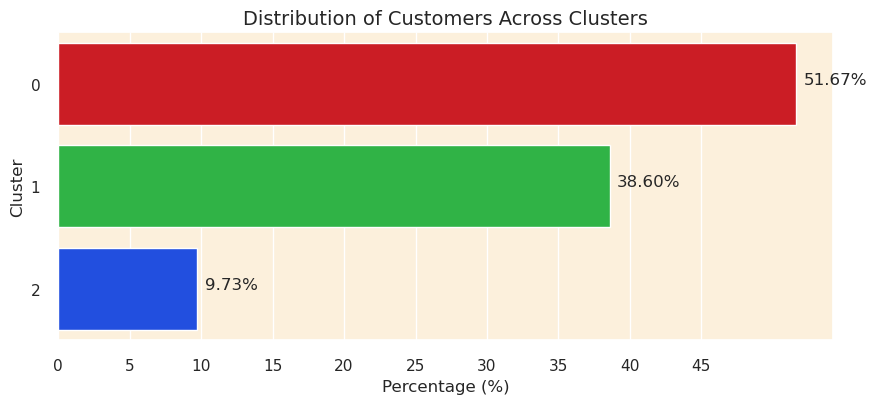

In [1022]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [1023]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        1891         |
|    Silhouette Score     | 0.24055191919252436 |
| Calinski Harabasz Score | 511.04046027870777  |
|  Davies Bouldin Score   | 1.3945030216342673  |
+-------------------------+---------------------+


## Profiling

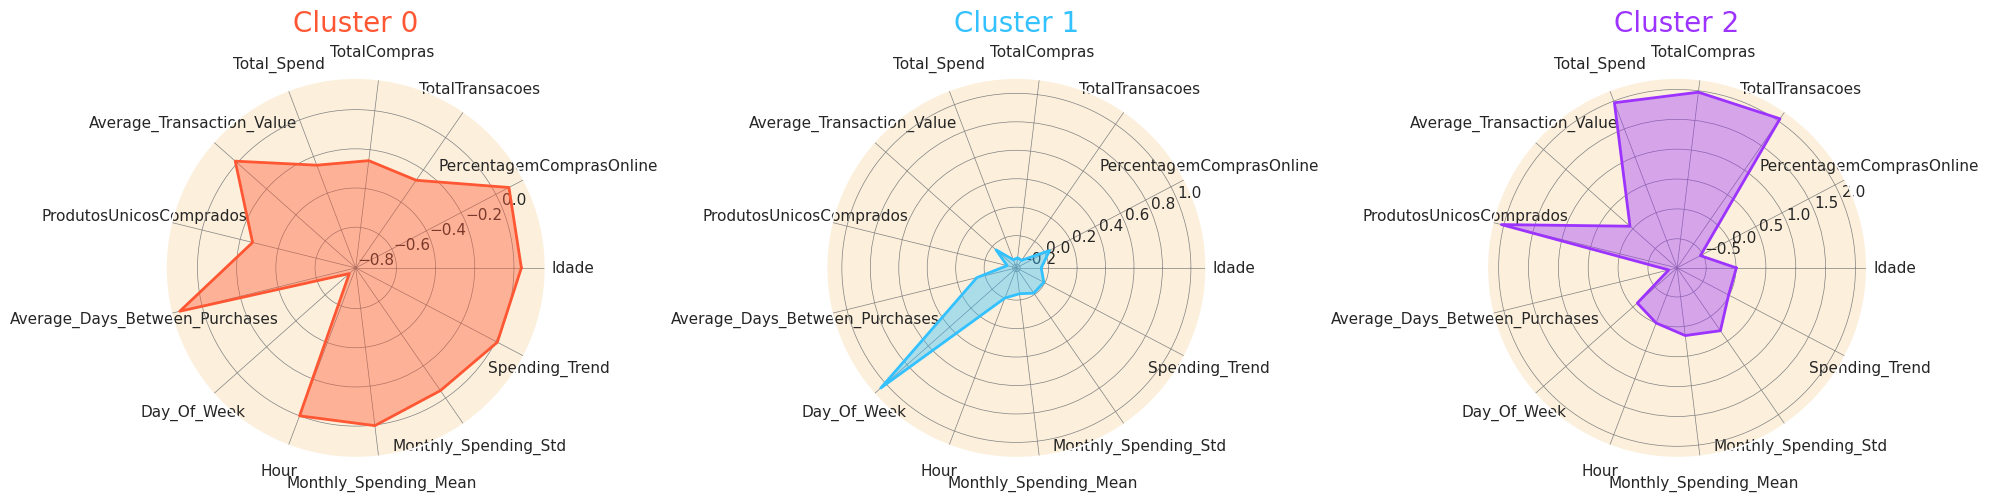

In [1024]:
df_customer = customer_data_cleaned.set_index('ClienteId')

# Keep only numeric columns for scaling (excluding 'cluster')
numeric_cols = df_customer.select_dtypes(include=np.number).drop(columns=['cluster'])

# Standardize the numeric data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(numeric_cols)

# Create a DataFrame with standardized values
df_customer_standardized = pd.DataFrame(
    standardized_values,
    columns=numeric_cols.columns,
    index=df_customer.index
)

# Add the 'cluster' column back
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot and fill
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Labels and number of variables
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop for circular radar
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Colors for clusters (customize as needed)
colors = ['#FF5733', '#33C1FF', '#9D33FF']  # Add or change depending on number of clusters

# Initialize radar chart figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar charts for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

    # Add labels and grid for each subplot
    ax[i].set_xticks(angles[:-1])
    ax[i].set_xticklabels(labels[:-1])
    ax[i].grid(color='grey', linewidth=0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()


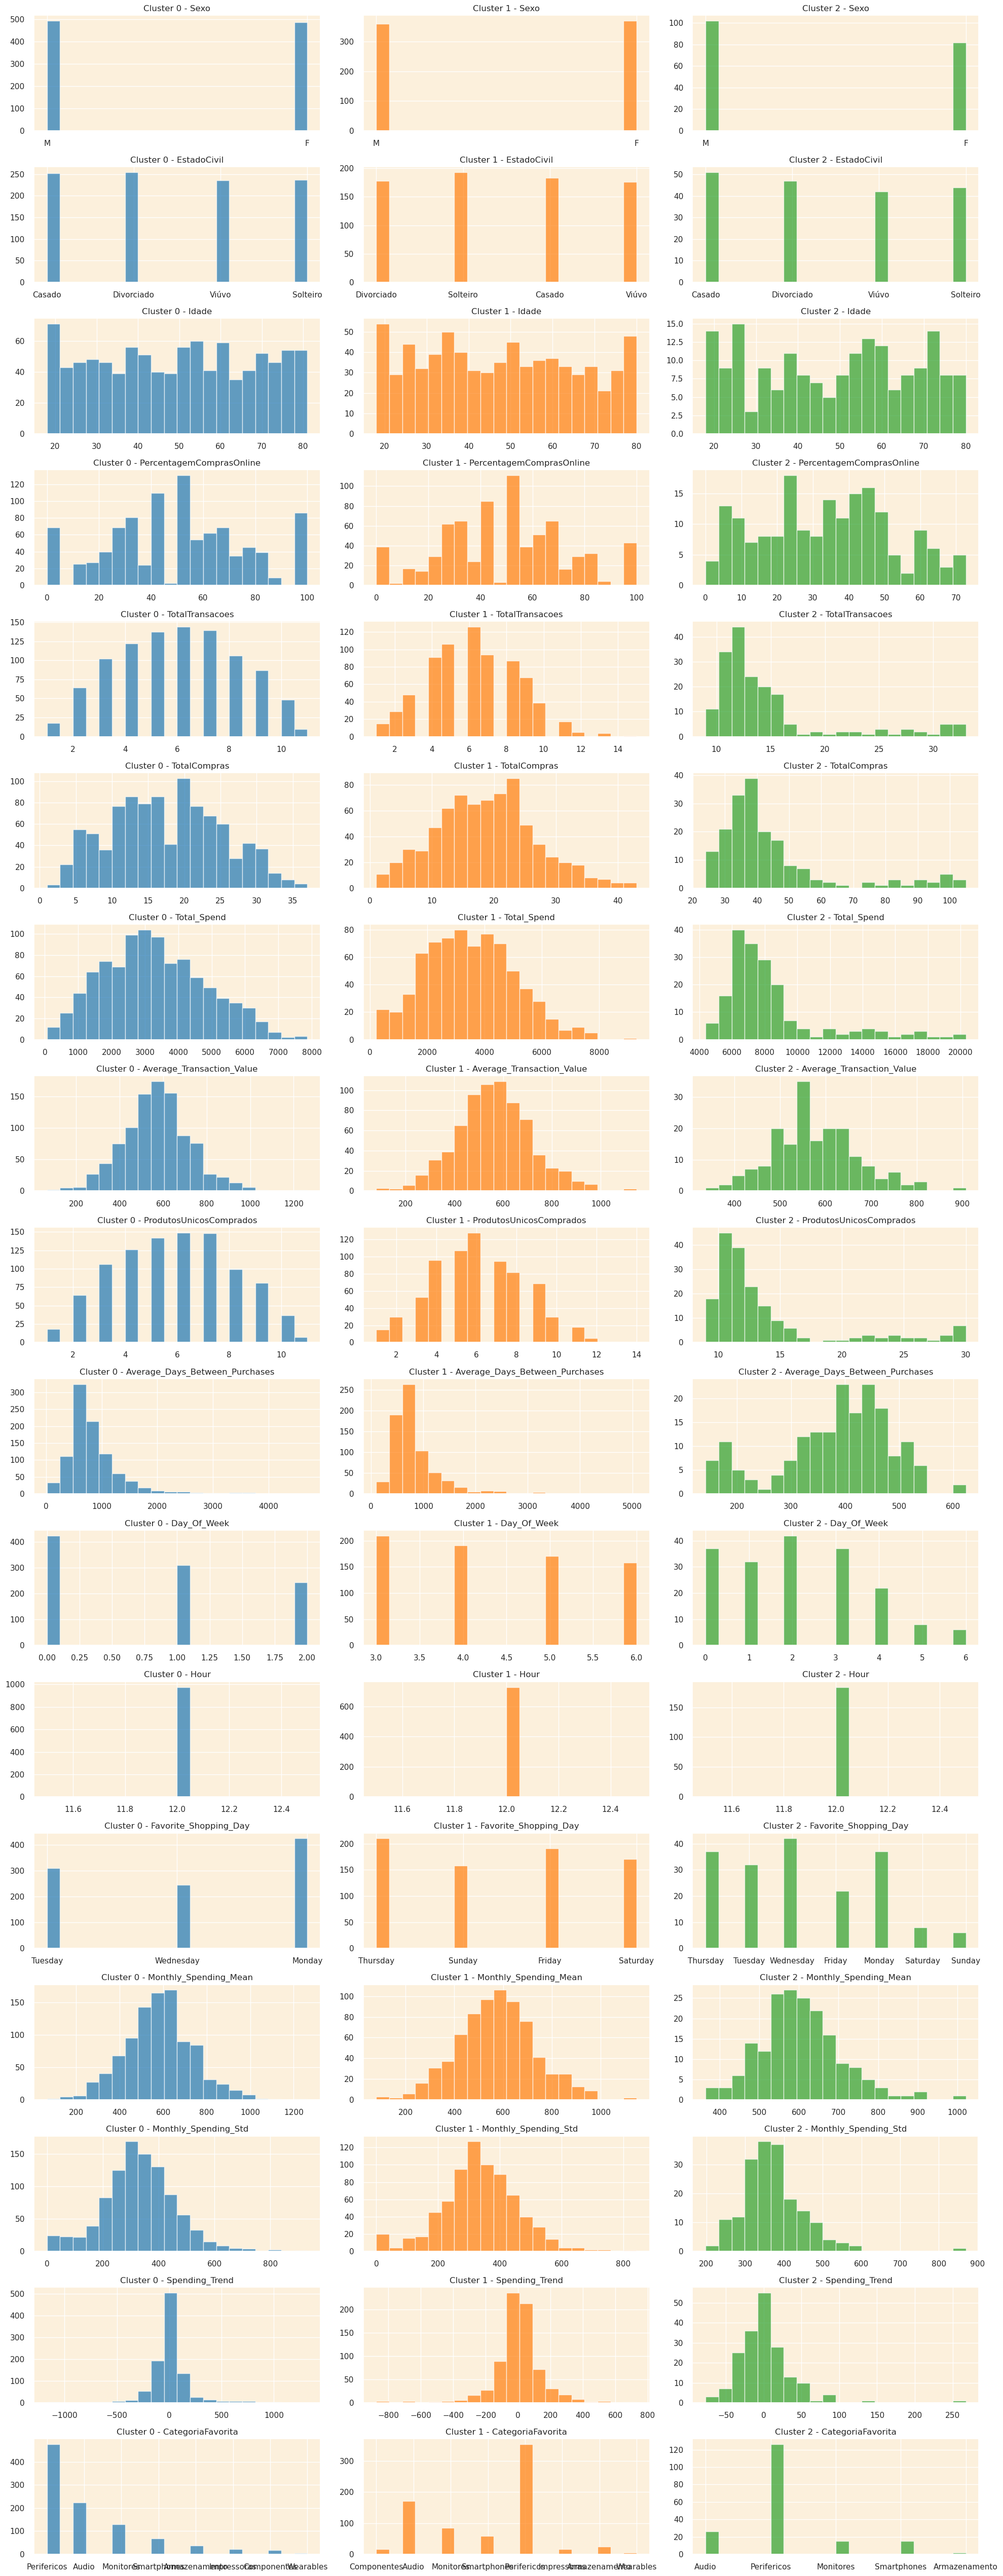

In [1025]:
import matplotlib.cm as cm

# Define features and clusters
features = customer_data_cleaned.drop(columns=['ClienteId', 'cluster', 'Nome', 'Profissao', 'Concelho', 'Distrito', 'DataNascimento']).columns
clusters = np.sort(customer_data_cleaned['cluster'].unique())
n_clusters = len(clusters)

# Setup color palette
colors = cm.tab10.colors[:n_clusters]

# Setup subplots
n_rows = len(features)
n_cols = n_clusters
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
axes = np.atleast_2d(axes)  # Ensure 2D indexing works

# Plot histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=12)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Tidy up layout
plt.tight_layout()
plt.show()


# **Sistemas de recomendação**

## Demographic filetering
Recomendação da trend de vendas para clientes novos sem dados

In [1026]:
# Determinar a data da compra mais antiga
df_vendas['DataId'] = pd.to_datetime(df_vendas['DataId'])

data_compra_mais_antiga = df_vendas['DataId'].min()

print(f"A compra mais antiga foi em: {data_compra_mais_antiga.date()}")

A compra mais antiga foi em: 2010-01-01


In [1027]:
hoje = datetime.now()
um_mes_atras = hoje - timedelta(days=365)

vendas_ultimo_mes = df_vendas[df_vendas['DataId'] >= um_mes_atras]

contagem_produtos = vendas_ultimo_mes['ProdutoId'].value_counts().reset_index()
contagem_produtos.columns = ['ProdutoId', 'NumeroVendas']

top_produtos = contagem_produtos.merge(df_produtos, on='ProdutoId', how='left')

top_30_produtos = top_produtos.head(30)

top_30_produtos


,ProdutoId,NumeroVendas,Nome,Marca,Categoria
0,132,16,Teclado Gaming Razer Cynosa V2,Razer,Perifericos
1,24,16,Headset Corsair Void Pro,Corsair,Audio
2,150,14,Smartphone OnePlus 10 Pro,OnePlus,Smartphones
3,123,13,Monitor 27 Polegadas AOC Agon,AOC,Monitores
4,108,13,"Monitor 27 Dell Alienware""",Dell,Monitores
5,101,13,Webcam Microsoft LifeCam HD,Microsoft,Perifericos
6,76,12,Rato Microsoft Surface Precision,Microsoft,Perifericos
7,3,12,Teclado Mecânico Corsair K70,Corsair,Perifericos
8,52,12,Teclado Logitech K380,Logitech,Perifericos
9,160,12,Smartphone Samsung Galaxy S22,Corsair,Perifericos


## Content-based filtering + Collaborative filtering
Recomendações para clientes existentes com algum histórico de comprar <br>
Basear as recomendações em hábitos de compra do cliente e hábitos de compra do cluster onde o cliente está inserido

### Content-based filtering

In [1028]:
# historico de compras de um dado cliente
def get_client_purchases(client_id, vendas_df):
    client_purchases = vendas_df[vendas_df['ClienteId'] == client_id]['ProdutoId'].unique()
    return client_purchases

In [1029]:
from sklearn.metrics.pairwise import cosine_similarity

# recomendar produtos
def recommend_products(client_id, vendas_df, produtos_df, top_n=10):
    # Get the client's purchase history
    purchased_products = get_client_purchases(client_id, vendas_df)
    
    if len(purchased_products) == 0:
        return "No purchase history for this client."
    
    # Create one-hot encoding for product categories and brands
    produtos_encoded = pd.get_dummies(produtos_df[['Categoria', 'Marca']])
    
    # Calculate the profile of purchased products
    client_profile = produtos_encoded.loc[produtos_df['ProdutoId'].isin(purchased_products)].mean(axis=0)
    
    # Calculate similarity between client profile and all products
    similarity_scores = []
    for idx, row in produtos_encoded.iterrows():
        sim_score = cosine_similarity([client_profile], [row])[0][0]
        similarity_scores.append((produtos_df.loc[idx, 'ProdutoId'], produtos_df.loc[idx, 'Nome'], sim_score))
    
    # Sort by similarity and filter out already purchased products
    similarity_scores.sort(key=lambda x: x[2], reverse=True)
    recommendations = [(prod_id, name) for prod_id, name, _ in similarity_scores 
                      if prod_id not in purchased_products]
    
    return recommendations[:top_n]

In [1030]:
example_customer_id = customer_data_cleaned['ClienteId'].iloc[0]
recomendations = recommend_products(example_customer_id, df_vendas, df_produtos, top_n=10)

print(f"\n----- CONTENT-BASED RECOMMENDATIONS FOR CLIENT {example_customer_id} -----")

df_recommendations = pd.DataFrame(recomendations, columns=['ProdutoId', 'Nome'])
display(df_recommendations)


----- CONTENT-BASED RECOMMENDATIONS FOR CLIENT 114 -----


,ProdutoId,Nome
0,1,Rato Logitech MX Master
1,2,Logitech Rato MX Anywhere
2,12,Teclado Logitech G Pro
3,27,Teclado Logitech MX Keys
4,52,Teclado Logitech K380
5,61,Rato Logitech G305
6,86,Webcam Logitech StreamCam
7,92,Teclado Logitech Craft
8,111,Rato Logitech G703
9,127,Teclado Logitech G915 TKL


### Collaborative filtering

In [1031]:
df_with_clusters = df_vendas.merge(customer_data_cleaned[['ClienteId', 'cluster']], on='ClienteId', how='inner')

print(f"Original transactions data shape: {df.shape}")
print(f"Merged data with clusters shape: {df_with_clusters.shape}")
print(f"Number of unique customers: {df_with_clusters['ClienteId'].nunique()}")


# Create a product purchase matrix: customers x products with purchase frequency
purchase_matrix = pd.crosstab(df_with_clusters['ClienteId'], df_with_clusters['ProdutoId'])

# Let's analyze product popularity by cluster
cluster_product_popularity = {}

for cluster_id in range(3):
    # Get customers in this cluster
    cluster_customers = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id]['ClienteId']
    
    # Filter transactions for this cluster
    cluster_transactions = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    # Calculate product popularity within this cluster
    product_counts = cluster_transactions.groupby('ProdutoId').agg(
        purchase_count=('VendaId', 'nunique'),
        customer_count=('ClienteId', 'nunique'),
        total_quantity=('Quantidade', 'sum'),
        total_revenue=('Total_Spend', 'sum')
    )
    
    # Calculate penetration rate (% of cluster customers who bought this product)
    cluster_customer_count = cluster_customers.nunique()
    product_counts['penetration_rate'] = product_counts['customer_count'] / cluster_customer_count * 100
    
    # Sort by popularity metrics
    popular_products = product_counts.sort_values(by=['penetration_rate', 'total_revenue'], ascending=False)
    
    # Store the results
    cluster_product_popularity[cluster_id] = popular_products

Original transactions data shape: (5182, 6)
Merged data with clusters shape: (12949, 19)
Number of unique customers: 1891


In [1032]:
df_vendas = pd.merge(df_vendas, df_produtos, on='ProdutoId')

In [1033]:
# Function to get top product recommendations for each cluster
def get_cluster_recommendations(cluster_id, top_n=10):
    popular_products = cluster_product_popularity[cluster_id].head(top_n)
    
    # Get product descriptions
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    recommendations = popular_products.reset_index().merge(
        product_info, on='ProdutoId', how='left'
    )
    
    return recommendations[['ProdutoId', 'Nome', 'purchase_count', 
                           'customer_count', 'penetration_rate', 
                           'total_quantity', 'total_revenue']]

In [1034]:
for cluster_id in range(3):
    print(f"\n----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER {cluster_id} -----")
    cluster_recs = get_cluster_recommendations(cluster_id, top_n=10)

    cluster_recs['penetration_rate'] = cluster_recs['penetration_rate'].map('{:.2f}'.format)
    cluster_recs['total_revenue'] = cluster_recs['total_revenue'].map('{:.2f}'.format)

    display(cluster_recs.reset_index(drop=True))


----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 0 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,3,Teclado Mecânico Corsair K70,49,48,4.91,134,30261.05
1,150,Smartphone OnePlus 10 Pro,50,48,4.91,141,27998.07
2,34,Headset SteelSeries Siberia,48,48,4.91,117,26366.54
3,84,Headset Sony WH-CH710N,47,47,4.81,113,29785.70
4,142,Teclado Corsair K65 Mini,47,47,4.81,147,26892.14
5,147,Teclado Gaming Keychron K4,47,46,4.71,149,23699.48
6,122,Teclado Ducky One 3,45,44,4.50,126,24801.89
7,86,Webcam Logitech StreamCam,44,44,4.50,142,24134.44
8,136,Webcam Razer Kiyo Pro,45,44,4.50,137,21529.67
9,62,Teclado Razer Ornata V2,43,43,4.40,137,25627.38



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 1 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,148,Monitor 32 Polegadas Acer,48,45,6.16,157,29726.25
1,114,Headset Razer Barracuda X,47,44,6.03,138,23761.74
2,59,Headset Corsair HS60,41,38,5.21,116,24331.87
3,150,Smartphone OnePlus 10 Pro,38,38,5.21,126,20292.98
4,79,Headset Bose QuietComfort 35,38,38,5.21,110,20226.64
5,1,Rato Logitech MX Master,39,38,5.21,110,18328.91
6,47,Teclado Gaming SteelSeries Apex 5,37,37,5.07,109,22923.81
7,88,SSD Crucial MX500 1TB,39,37,5.07,135,18960.08
8,119,Impressora HP LaserJet Pro M15w,36,36,4.93,107,19771.51
9,137,Placa Gráfica ASUS TUF RTX 3090,36,36,4.93,107,19622.62



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 2 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,104,Impressora Brother HL-L2350DW,28,28,15.22,76,17224.28
1,129,Headset Sennheiser Momentum 3,29,26,14.13,95,12352.77
2,40,Smartphone Samsung Galaxy S20,25,25,13.59,73,13346.16
3,113,Monitor 24 Polegadas ASUS ROG,25,23,12.50,70,13328.98
4,94,Headset JBL Live 650BTNC,23,23,12.50,66,12289.84
5,80,Smartphone OnePlus 9,25,22,11.96,75,14955.81
6,18,"Monitor 32 LG""",22,22,11.96,80,14618.83
7,77,Teclado Mecânico Kinesis Freestyle,23,22,11.96,72,12719.13
8,44,Headset Logitech G Pro X,22,22,11.96,69,11915.29
9,57,Teclado Ducky Shine 7,25,22,11.96,80,11529.00


In [1035]:
# Create a function to get personalized recommendations for a specific customer
def get_customer_recommendations(customer_id, n_recommendations=5):
    # Find the customer's cluster
    try:
        customer_cluster = customer_data_cleaned[
            customer_data_cleaned['ClienteId'] == customer_id
        ]['cluster'].values[0]
    except IndexError:
        return "Customer not found in the cluster data."
    
    # Get the customer's purchase history
    customer_purchases = df_vendas[df_vendas['ClienteId'] == customer_id]['ProdutoId'].unique()
    
    # Get popular products in the customer's cluster
    cluster_popular = cluster_product_popularity[customer_cluster]
    
    # Filter out products the customer has already purchased
    new_recommendations = cluster_popular[
        ~cluster_popular.index.isin(customer_purchases)
    ].head(n_recommendations)
    
    # Get product descriptions
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    recommendations = new_recommendations.reset_index().merge(
        product_info, on='ProdutoId', how='left'
    )
    
    return recommendations[['ProdutoId', 'Nome', 'penetration_rate', 'total_revenue']]

In [1036]:
print(f"\n----- PERSONALIZED RECOMMENDATIONS FOR CUSTOMER {example_customer_id} -----")
customer_recs = get_customer_recommendations(example_customer_id, n_recommendations=10)

customer_recs['penetration_rate'] = customer_recs['penetration_rate'].map('{:.2f}'.format)
customer_recs['total_revenue'] = customer_recs['total_revenue'].map('{:.2f}'.format)

display(customer_recs.reset_index(drop=True))


----- PERSONALIZED RECOMMENDATIONS FOR CUSTOMER 114 -----


,ProdutoId,Nome,penetration_rate,total_revenue
0,104,Impressora Brother HL-L2350DW,15.22,17224.28
1,129,Headset Sennheiser Momentum 3,14.13,12352.77
2,40,Smartphone Samsung Galaxy S20,13.59,13346.16
3,113,Monitor 24 Polegadas ASUS ROG,12.50,13328.98
4,94,Headset JBL Live 650BTNC,12.50,12289.84
5,80,Smartphone OnePlus 9,11.96,14955.81
6,18,"Monitor 32 LG""",11.96,14618.83
7,77,Teclado Mecânico Kinesis Freestyle,11.96,12719.13
8,44,Headset Logitech G Pro X,11.96,11915.29
9,57,Teclado Ducky Shine 7,11.96,11529.00



----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----
   ProdutoId                             Nome  customer_count  total_revenue  \
0        150        Smartphone OnePlus 10 Pro             100     58145.6942   
1        136            Webcam Razer Kiyo Pro              89     56569.9328   
2        132   Teclado Gaming Razer Cynosa V2              75     49842.1066   
3        134     Headset SteelSeries Arctis 1              76     47940.8271   
4        105        Smartwatch Fitbit Versa 3              71     47668.3654   
5        130        Smartphone Google Pixel 6              80     47404.9011   
6         79     Headset Bose QuietComfort 35              82     46472.0104   
7         35             Smartphone iPhone 12              71     46328.6356   
8        140  Smartwatch Apple Watch Series 7              73     44681.5156   
9         12           Teclado Logitech G Pro              78     44363.7180   

   cluster_0_penetration  cluster_1_penetration  cluste

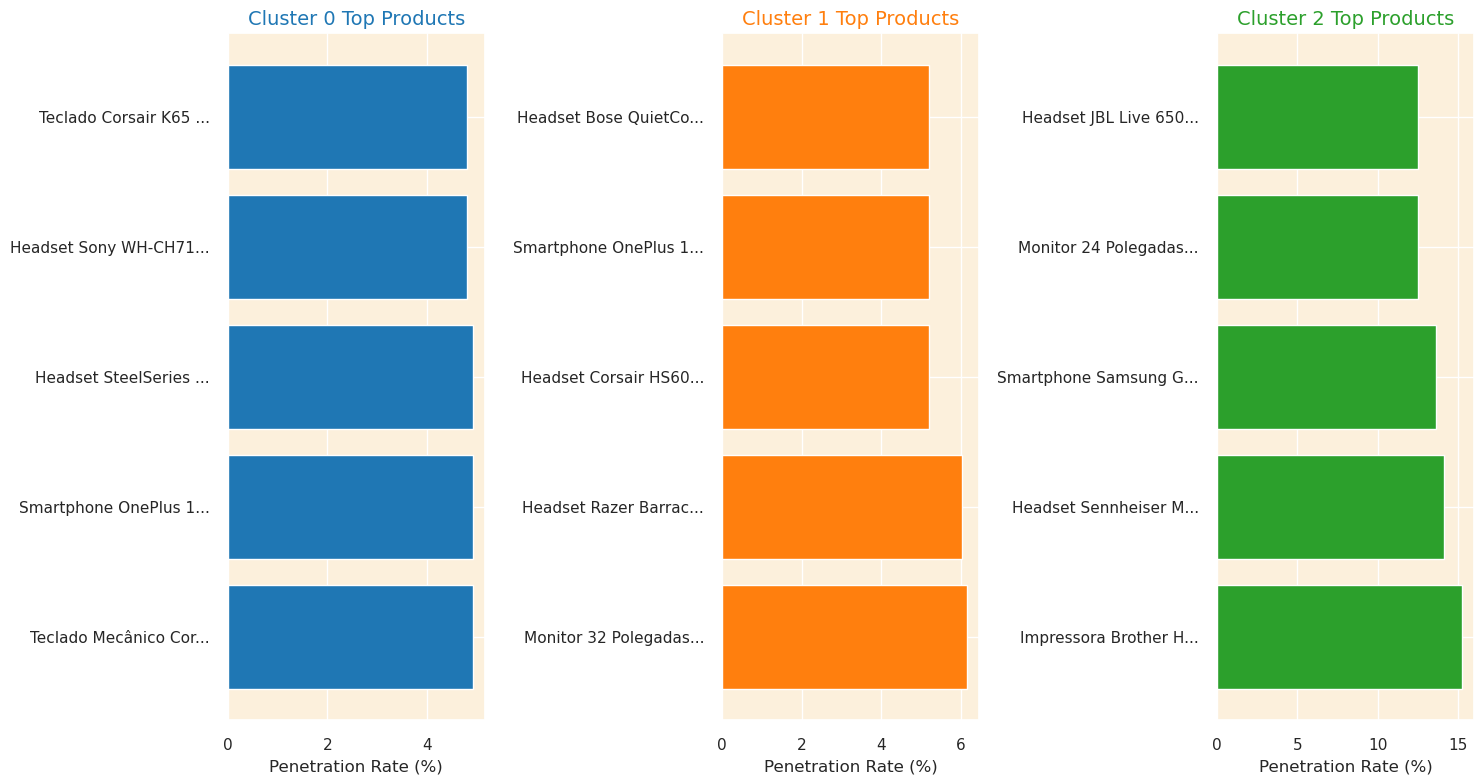


----- CLUSTER PROFILES FOR MARKETING RECOMMENDATIONS -----

CLUSTER 0 PROFILE:
Size: 977 customers (51.67% of total)
Average transactions per customer: 5.82
Average total spend: $3299.22
Average transaction value: $569.52
Average Age: $49.27
Average online purchases percentage: 33.53
Top product categories:
  - Teclado Mecânico Corsair K70 (Penetration: 4.91%)
  - Smartphone OnePlus 10 Pro (Penetration: 4.91%)
  - Headset SteelSeries Siberia (Penetration: 4.91%)

CLUSTER 1 PROFILE:
Size: 730 customers (38.60% of total)
Average transactions per customer: 6.22
Average total spend: $3487.37
Average transaction value: $562.30
Average Age: $47.62
Average online purchases percentage: 33.53
Top product categories:
  - Monitor 32 Polegadas Acer (Penetration: 6.16%)
  - Headset Razer Barracuda X (Penetration: 6.03%)
  - Headset Corsair HS60 (Penetration: 5.21%)

CLUSTER 2 PROFILE:
Size: 184 customers (9.73% of total)
Average transactions per customer: 14.83
Average total spend: $8436.13
Averag

In [1037]:
# Let's analyze cross-cluster recommendations
# This will help identify products that are popular across multiple clusters
# and could be good candidates for general promotions

# Calculate product popularity across all clusters
all_product_stats = df_with_clusters.groupby('ProdutoId').agg(
    purchase_count=('VendaId', 'nunique'),
    customer_count=('ClienteId', 'nunique'),
    total_quantity=('Quantidade', 'sum'),
    total_revenue=('Total_Spend', 'sum')
)

# Calculate popularity within each cluster
cluster_product_matrix = {}
for cluster_id in range(3):
    cluster_txns = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    product_stats = cluster_txns.groupby('ProdutoId').agg(
        customer_count=('ClienteId', 'nunique')
    )
    
    cluster_size = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id].shape[0]
    product_stats[f'cluster_{cluster_id}_penetration'] = product_stats['customer_count'] / cluster_size * 100
    
    cluster_product_matrix[cluster_id] = product_stats

# Combine the cluster-specific statistics
cross_cluster_stats = all_product_stats.copy()
for cluster_id in range(3):
    cross_cluster_stats = cross_cluster_stats.join(
        cluster_product_matrix[cluster_id][f'cluster_{cluster_id}_penetration'],
        how='left'
    )

# Calculate variance of penetration across clusters to find products with universal appeal
cross_cluster_stats['penetration_variance'] = cross_cluster_stats[[
    f'cluster_{i}_penetration' for i in range(3)
]].var(axis=1)

# Fill NaN values (products not purchased in some clusters)
cross_cluster_stats = cross_cluster_stats.fillna(0)

# Identify products with high penetration across all clusters (universal appeal)
universal_products = cross_cluster_stats[
    (cross_cluster_stats['penetration_variance'] < cross_cluster_stats['penetration_variance'].quantile(0.25)) &
    (cross_cluster_stats[f'cluster_0_penetration'] > 0) &
    (cross_cluster_stats[f'cluster_1_penetration'] > 0) &
    (cross_cluster_stats[f'cluster_2_penetration'] > 0)
].sort_values(by='total_revenue', ascending=False)

# Get descriptions for universal appeal products
universal_with_desc = universal_products.reset_index().merge(
    df_vendas[['ProdutoId', 'Nome']].drop_duplicates(),
    on='ProdutoId',
    how='left'
)

print("\n----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----")
print(universal_with_desc[['ProdutoId', 'Nome', 'customer_count', 
                          'total_revenue', 'cluster_0_penetration',
                          'cluster_1_penetration', 'cluster_2_penetration']].head(10))

# Visualize the top products by cluster
plt.figure(figsize=(15, 8))

for i, cluster_id in enumerate(range(3)):
    top_products = cluster_product_popularity[cluster_id].head(5).reset_index()
    
    # Get product descriptions (take first 20 chars to keep chart readable)
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    top_products = top_products.merge(product_info, on='ProdutoId', how='left')
    top_products['short_desc'] = top_products['Nome'].str[:20] + '...'
    
    plt.subplot(1, 3, i+1)
    plt.barh(top_products['short_desc'], top_products['penetration_rate'], color=colors[i])
    plt.title(f'Cluster {cluster_id} Top Products', fontsize=14, color=colors[i])
    plt.xlabel('Penetration Rate (%)')
    plt.tight_layout()

plt.savefig('cluster_top_products.png')
plt.show()

# Create cluster profiles summary for marketing recommendations
cluster_profiles = {}

for cluster_id in range(3):
    # Get average values for key metrics in this cluster
    cluster_data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id]
    
    profile = {
        'size': cluster_data.shape[0],
        'size_percentage': cluster_data.shape[0] / customer_data_cleaned.shape[0] * 100,
        'avg_total_transactions': cluster_data['TotalTransacoes'].mean(),
        'avg_total_spend': cluster_data['Total_Spend'].mean(),
        'avg_transaction_value': cluster_data['Average_Transaction_Value'].mean(),
        'Idade': cluster_data['Idade'].mean(),
        'PercentagemComprasOnline': cluster_data['PercentagemComprasOnline'],
        'top_products': get_cluster_recommendations(cluster_id, top_n=5)
    }
    
    cluster_profiles[cluster_id] = profile

# Print marketing profile summaries
print("\n----- CLUSTER PROFILES FOR MARKETING RECOMMENDATIONS -----")
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCLUSTER {cluster_id} PROFILE:")
    print(f"Size: {profile['size']} customers ({profile['size_percentage']:.2f}% of total)")
    print(f"Average transactions per customer: {profile['avg_total_transactions']:.2f}")
    print(f"Average total spend: ${profile['avg_total_spend']:.2f}")
    print(f"Average transaction value: ${profile['avg_transaction_value']:.2f}")
    print(f"Average Age: ${profile['Idade']:.2f}")
    profile['PercentagemComprasOnline'] = cluster_data['PercentagemComprasOnline'].mean()
    print(f"Average online purchases percentage: {profile['PercentagemComprasOnline']:.2f}")
    print("Top product categories:")
    for _, row in profile['top_products'].head(3).iterrows():
        print(f"  - {row['Nome']} (Penetration: {row['penetration_rate']:.2f}%)")

### Recomendação Híbrida com média ponderada
- Peso do collaborative filtering: 0.4
- Peso do content-based filtering: 0.6

In [1038]:
def convert_to_scored(recommendations):
    n = len(recommendations)
    return [(prod_id, name, (n - i) / n) for i, (prod_id, name) in enumerate(recommendations)]

def combine_recommendations(content_recommendations, collaborative_recommendations, top_n=10, w_content=0.6, w_collab=0.4):
    content_scored = convert_to_scored(content_recommendations)
    collab_scored = convert_to_scored(collaborative_recommendations)

    combined_dict = {}

    for prod_id, name, score in content_scored:
        combined_dict[prod_id] = {'name': name, 'content_score': score, 'collab_score': 0}

    for prod_id, name, score in collab_scored:
        if prod_id in combined_dict:
            combined_dict[prod_id]['collab_score'] = score
        else:
            combined_dict[prod_id] = {'name': name, 'content_score': 0, 'collab_score': score}

    combined_scores = []
    for prod_id, data in combined_dict.items():
        final_score = w_content * data['content_score'] + w_collab * data['collab_score']
        combined_scores.append((prod_id, data['name'], final_score))

    combined_scores.sort(key=lambda x: x[2], reverse=True)
    return combined_scores[:top_n]

In [1039]:
customer_recs_list = list(customer_recs[['ProdutoId', 'Nome']].itertuples(index=False, name=None))
combined_recommendations = combine_recommendations(recomendations, customer_recs_list, top_n=10)

In [1040]:
df_combined = pd.DataFrame(combined_recommendations, columns=['ProdutoId', 'Nome', 'Score'])

df_combined = df_combined.sort_values(by='Score', ascending=False)

df_combined['Score'] = df_combined['Score'].map('{:.2f}'.format)

print(f"\n----- COMBINED RECOMMENDATIONS FOR CLIENT {example_customer_id} -----")
display(df_combined.reset_index(drop=True))


----- COMBINED RECOMMENDATIONS FOR CLIENT 114 -----


,ProdutoId,Nome,Score
0,1,Rato Logitech MX Master,0.60
1,2,Logitech Rato MX Anywhere,0.54
2,12,Teclado Logitech G Pro,0.48
3,27,Teclado Logitech MX Keys,0.42
4,104,Impressora Brother HL-L2350DW,0.40
5,129,Headset Sennheiser Momentum 3,0.36
6,52,Teclado Logitech K380,0.36
7,40,Smartphone Samsung Galaxy S20,0.32
8,61,Rato Logitech G305,0.30
9,113,Monitor 24 Polegadas ASUS ROG,0.28
